# Gesture Recognition - DSC27 - Group Case Study

- Neha Purohit
- Ramanpreet Singh

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [3]:
import numpy as np
import os
#from scipy.misc import imread, imresize --- DEPRECATED
import datetime
import os
from matplotlib import pyplot as plt
from skimage.io import imread, imshow # Used in place of outdated scipy packages
from skimage.transform import resize as imresize

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.set_random_seed(30) -- DEPRECATED

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
folders = []
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    cropped = image[10:(image.shape[0]-10),10:(image.shape[1]-10)] # Cropping Image
                    resized = imresize(cropped, (img_height, img_width, 3)) # Resizing Image             
                    #image = (image - image.min())/(image.max() - image.min()) 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    
                    batch_data[folder,idx,:,:,0] = (resized[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:# This is also the number of sequences left to process
            new_batch_size = len(folder_list)%batch_size
            last_seq_yielded = num_batches*batch_size
            batch_data = np.zeros((new_batch_size,len(img_idx),img_height,img_width,3))
            batch_labels = np.zeros((new_batch_size,5))
            count = 0
            for i in range(last_seq_yielded,len(folder_list)):
                imgs = os.listdir(source_path+'/'+ t[i].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[i].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    cropped = image[10:(image.shape[0]-10),10:(image.shape[1]-10)]
                    resized = imresize(cropped, (img_height, img_width, 3))        
                    #image = (image - image.min())/(image.max() - image.min()) 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    

                    batch_data[count,idx,:,:,0] = (resized[:,:,0])/255#normalise and feed in the image
                    batch_data[count,idx,:,:,1] = (resized[:,:,1])/255#normalise and feed in the image
                    batch_data[count,idx,:,:,2] = (resized[:,:,2])/255#normalise and feed in the image
                    batch_labels[count, int(t[i].strip().split(';')[2])] = 1
                count+=1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
def compile_model(model):
    optimiser = 'adam'#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
def gen_data():
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    return train_generator, val_generator

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
def initialize_step_count():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
def fit_model(model):
    hist = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return(hist)

In [14]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])


In [14]:
batch_size = 10
num_epochs = 5
img_height = 50
img_width = 50
train_generator, val_generator = gen_data()
steps_per_epoch, validation_steps = initialize_step_count()
print("Batch Size = ", batch_size)
print("Epochs = ", num_epochs)
print("Steps Per Epoch = ", steps_per_epoch)
print("Validation Steps = ", validation_steps)
print("Image Dimensions = ", img_height, " X ", img_width)

Batch Size =  10
Epochs =  5
Steps Per Epoch =  67
Validation Steps =  10
Image Dimensions =  50  X  50


In [15]:
# Model 1

#write your model here

num_classes = 5
sample_shape = (15, img_height, img_width, 3)
model1 = Sequential()
model1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu',
                  kernel_initializer='he_uniform', input_shape=sample_shape))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Conv3D(64, kernel_size=(3, 3, 3),
                  activation='relu', kernel_initializer='he_uniform'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dense(num_classes, activation='softmax'))


In [16]:
#Model 1
compile_model(model1)
hist = fit_model(model1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 48, 48, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 24, 24, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 22, 22, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 11, 11, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 256)               3

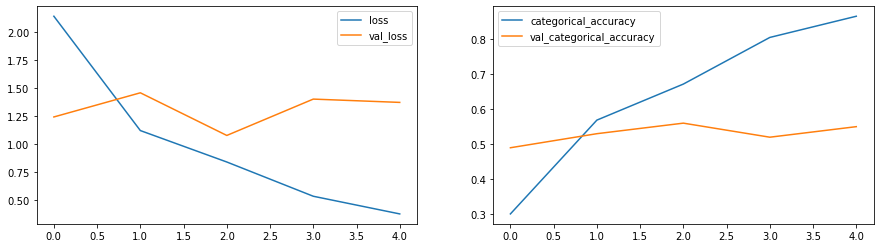

In [17]:
plot(hist)

As per above model plot (conv3d)
High Categorical Accuracy but low stable validation accuracy showing a sign of overfitting

In [38]:
#Model 2 - Added Batch Normalization
batch_size = 20
num_epochs = 10
img_height = 70
img_width = 70
train_generator, val_generator = gen_data()
steps_per_epoch, validation_steps = initialize_step_count()
print("Batch Size = ", batch_size)
print("Epochs = ", num_epochs)
print("Steps Per Epoch = ", steps_per_epoch)
print("Validation Steps = ", validation_steps)
print("Image Dimensions = ", img_height, " X ", img_width)

Batch Size =  20
Epochs =  10
Steps Per Epoch =  34
Validation Steps =  5
Image Dimensions =  70  X  70


In [19]:
# Model 2

#write your model here

num_classes = 5
sample_shape = (15, img_height, img_width, 3)
model2 = Sequential()
model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu',
                  kernel_initializer='he_uniform', input_shape=sample_shape))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Conv3D(64, kernel_size=(3, 3, 3),
                  activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(num_classes, activation='softmax'))


In [20]:
#Model 2
compile_model(model2)
hist2 = fit_model(model2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 68, 68, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 13, 68, 68, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 34, 34, 32)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 4, 32, 32, 64)     55360     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 32, 32, 64)    256       
 hNormalization)                                                 
                                                      

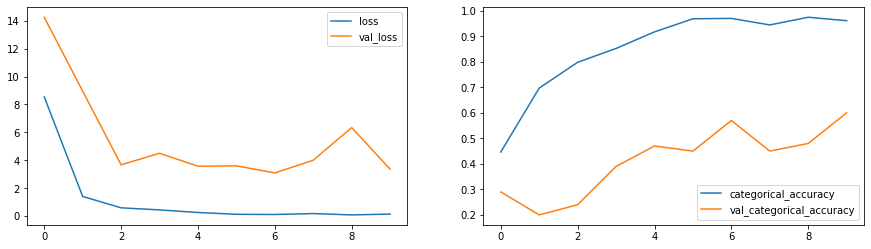

In [22]:
plot(hist2)

As per above plot for conv3 with batch normalization, overfitting is removed however val accuracy is very low hence this model is not acceptable

In [23]:
# Model 3
batch_size = 10
num_epochs = 20
img_height = 100
img_width = 100
train_generator, val_generator = gen_data()
steps_per_epoch, validation_steps = initialize_step_count()
print("Batch Size = ", batch_size)
print("Epochs = ", num_epochs)
print("Steps Per Epoch = ", steps_per_epoch)
print("Validation Steps = ", validation_steps)
print("Image Dimensions = ", img_height, " X ", img_width)

Batch Size =  10
Epochs =  20
Steps Per Epoch =  67
Validation Steps =  10
Image Dimensions =  100  X  100


In [24]:
# CNN + RNN

num_classes = 5
model3 = Sequential()
sample_shape = (15, img_height, img_width, 3)
model3.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',
                                  activation='relu'), input_shape=sample_shape))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(TimeDistributed(
    Conv2D(32, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(TimeDistributed(
    Conv2D(64, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(TimeDistributed(
    Conv2D(128, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(TimeDistributed(
    Conv2D(256, (3, 3), padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(TimeDistributed(Flatten()))
model3.add(GRU(64))
model3.add(Dropout(0.25))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(num_classes, activation='softmax'))


In [25]:
#Model 3
compile_model(model3)
hist3 = fit_model(model3)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 50, 50, 32)  

Epoch 13/20
67/67 [==============================] - ETA: 0s - loss: 0.4553 - categorical_accuracy: 0.8326
Epoch 00013: val_loss did not improve from 0.69783
67/67 [==============================] - 310s 5s/step - loss: 0.4553 - categorical_accuracy: 0.8326 - val_loss: 1.0916 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 14/20
67/67 [==============================] - ETA: 0s - loss: 0.4866 - categorical_accuracy: 0.7979
Epoch 00014: val_loss did not improve from 0.69783
67/67 [==============================] - 303s 5s/step - loss: 0.4866 - categorical_accuracy: 0.7979 - val_loss: 0.7178 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 15/20
67/67 [==============================] - ETA: 0s - loss: 0.4669 - categorical_accuracy: 0.8175
Epoch 00015: val_loss did not improve from 0.69783
67/67 [==============================] - 302s 5s/step - loss: 0.4669 - categorical_accuracy: 0.8175 - val_loss: 1.0410 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 16/20
67/67 [======

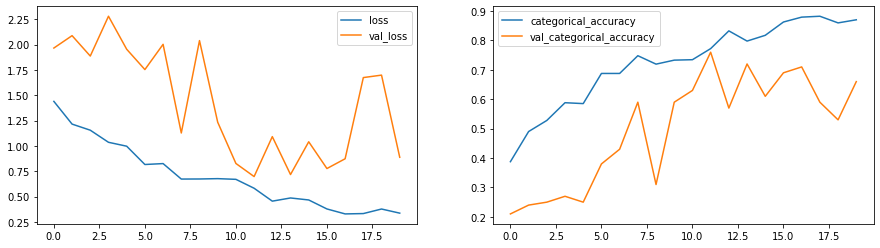

In [26]:
plot(hist3)

In [ ]:
As per above plot for conv2d + GRU with batch normalization, overfitting is removed however val accuracy is very low hence this model is not acceptable

In [15]:
# Model 4
batch_size = 32
num_epochs = 15
img_height = 100
img_width = 100
train_generator, val_generator = gen_data()
steps_per_epoch, validation_steps = initialize_step_count()
print("Batch Size = ", batch_size)
print("Epochs = ", num_epochs)
print("Steps Per Epoch = ", steps_per_epoch)
print("Validation Steps = ", validation_steps)
print("Image Dimensions = ", img_height, " X ", img_width)

Batch Size =  32
Epochs =  15
Steps Per Epoch =  21
Validation Steps =  4
Image Dimensions =  100  X  100


In [17]:
from keras.applications import mobilenet
input_shape= (15, img_height, img_width, 3)
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model4 = Sequential()
model4.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
for layer in model4.layers:
    layer.trainable = False
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))
    model4.add(TimeDistributed(Flatten()))

    model4.add(GRU(128))
    model4.add(Dropout(0.5))
          
    model4.add(Dense(128,activation='relu'))
    model4.add(Dropout(0.25))
          
    model4.add(Dense(5, activation='softmax'))

In [ ]:
#Model 4
compile_model(model4)
hist4 = fit_model(model4)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

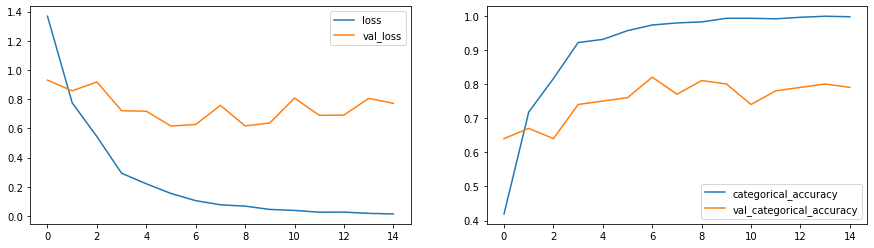

In [23]:
plot(hist4)

After doing all the experiments, we finalized **Conv2d + GRU ( with transfer learning)** model which performed well

#### **Reason**;
1. Training Accuracy: 77% , Validation Accuracy: 76%
2. Number of Trainable Parameters are 0.3 Million which is lesser compare to other models performance
3. Learning rate gradually decreasing after some Epochs
